<a href="https://colab.research.google.com/github/OpenArCloud/openvps/blob/main/OpenVPS_hLoc_w_MSF_dataset_PoC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Open Visual Positioning System (VPS) - hLoc w/MSF dataset PoC

Baseline of visual mapping and localization using COLMAP (https://colmap.github.io/) and hLoc (https://github.com/cvg/Hierarchical-Localization). Adapted from the original hLoc demo but using the [MSF dataset](https://github.com/HillyfieldsBubble/Releases/tree/main/MSF_Prototype_Dataset) (Rider-4 PNGs from GoPro for mapping, Rider-4 PNGs from Nokia 5 for localization) and NETVLAD image retrieval instead of exhaustive matching.

Mapping takes ~32 mins on A100.

OpenVPS project: https://github.com/OpenArCloud/openvps

Real/Virtual World Integration project: https://github.com/MetaverseStandards/Virtual-Real-Integration

Contact: [james.jackson@openarcloud.org](mailto:james.jackson@openarcloud.org)

# Check GPU

In [ ]:
!nvidia-smi

Fri Jul 26 17:48:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0              49W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Install HLoc

See https://github.com/cvg/Hierarchical-Localization

In [ ]:
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
%cd Hierarchical-Localization
!pip install --progress-bar off --quiet -e .
!pip install --progress-bar off --quiet --upgrade plotly

import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive, pairs_from_retrieval
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

/content/Hierarchical-Localization
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Setup
Here we define some output paths. We will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [ ]:
images = Path('datasets/msf_rider4')
outputs = Path('outputs/msf/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']
retrieval_conf = extract_features.confs['netvlad']

# Download Dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data and refined with SfM.


In [ ]:
!pip install gdown

if not images.exists():
    !gdown https://drive.google.com/uc?id=1GfFMpnBHzLBUccVqPST_5WMYuQjnRzgU
    !unzip -q msf_rider4.zip -d datasets/

Downloading...
From (original): https://drive.google.com/uc?id=1GfFMpnBHzLBUccVqPST_5WMYuQjnRzgU
From (redirected): https://drive.google.com/uc?id=1GfFMpnBHzLBUccVqPST_5WMYuQjnRzgU&confirm=t&uuid=4331980a-3b85-4a38-a906-f69cf8e0452d
To: /content/Hierarchical-Localization/msf_rider4.zip
100% 3.08G/3.08G [00:30<00:00, 99.7MB/s]


# 3D mapping
First we list the images used for mapping.

221 mapping images


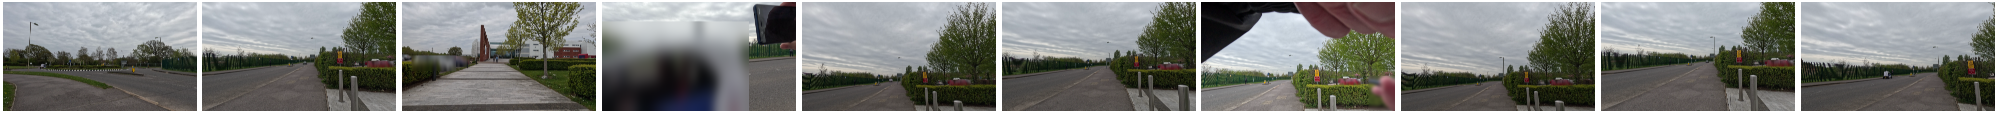

In [ ]:
import random
references = [str(p.relative_to(images)) for p in (images).iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in random.sample(references, 10)], dpi=25)

# Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [ ]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)

[2024/07/26 17:59:29 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/07/26 17:59:29 hloc INFO] Found 221 images in root datasets/msf_rider4.


  0%|          | 0.00/529M [00:00<?, ?B/s]

  0%|          | 0/221 [00:00<?, ?it/s]

[2024/07/26 18:02:00 hloc INFO] Finished exporting features.
[2024/07/26 18:02:00 hloc INFO] Extracting image pairs from a retrieval database.
[2024/07/26 18:02:01 hloc INFO] Found 1105 pairs.


# Extract and match local features


In [ ]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

[2024/07/26 18:03:39 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
[2024/07/26 18:03:39 hloc INFO] Found 221 images in root datasets/msf_rider4.
Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /root/.cache/torch/hub/checkpoints/depth-save.pth


  0%|          | 0.00/4.17M [00:00<?, ?B/s]

  0%|          | 0/221 [00:00<?, ?it/s]

[2024/07/26 18:05:43 hloc INFO] Finished exporting features.
[2024/07/26 18:05:43 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/disk_lightglue.pth" to /root/.cache/torch/hub/checkpoints/disk_lightglue_v0-1_arxiv.pth


  0%|          | 0.00/45.4M [00:00<?, ?B/s]

  0%|          | 0/761 [00:00<?, ?it/s]

[2024/07/26 18:06:35 hloc INFO] Finished exporting matches.


The we run incremental Structure-from-Motion...

In [ ]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path, image_list=references)

[2024/07/26 18:06:48 hloc INFO] Creating an empty database...
[2024/07/26 18:06:48 hloc INFO] Importing images into the database...
[2024/07/26 18:08:07 hloc INFO] Importing features into the database...


  0%|          | 0/221 [00:00<?, ?it/s]

[2024/07/26 18:08:08 hloc INFO] Importing matches into the database...


  0%|          | 0/1105 [00:00<?, ?it/s]

[2024/07/26 18:08:09 hloc INFO] Performing geometric verification of the matches...
[2024/07/26 18:08:17 hloc INFO] Running 3D reconstruction...
[2024/07/26 18:39:23 hloc INFO] Reconstructed 2 model(s).
[2024/07/26 18:39:23 hloc INFO] Largest model is #0 with 201 images.
[2024/07/26 18:39:23 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 201
	num_cameras = 201
	num_points3D = 29628
	num_observations = 385417
	mean_track_length = 13.0085
	mean_observations_per_image = 1917.5
	mean_reprojection_error = 1.53483
	num_input_images = 221


and display the reconstructed 3D model:

In [ ]:
!zip -r /content/Hierarchical-Localization/outputs/msf.zip /content/Hierarchical-Localization/outputs/msf/

  adding: content/Hierarchical-Localization/outputs/msf/ (stored 0%)
  adding: content/Hierarchical-Localization/outputs/msf/feats-disk_matches-disk-lightglue_pairs-sfm.h5 (deflated 51%)
  adding: content/Hierarchical-Localization/outputs/msf/pairs-sfm.txt (deflated 95%)
  adding: content/Hierarchical-Localization/outputs/msf/sfm/ (stored 0%)
  adding: content/Hierarchical-Localization/outputs/msf/sfm/models/ (stored 0%)
  adding: content/Hierarchical-Localization/outputs/msf/sfm/models/1/ (stored 0%)
  adding: content/Hierarchical-Localization/outputs/msf/sfm/models/1/images.bin (deflated 84%)
  adding: content/Hierarchical-Localization/outputs/msf/sfm/models/1/points3D.bin (deflated 36%)
  adding: content/Hierarchical-Localization/outputs/msf/sfm/models/1/cameras.bin (deflated 61%)
  adding: content/Hierarchical-Localization/outputs/msf/sfm/models/0/ (stored 0%)
  adding: content/Hierarchical-Localization/outputs/msf/sfm/database.db (deflated 55%)
  adding: content/Hierarchical-Local

In [ ]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

We also visualize which keypoints were triangulated into the 3D model.

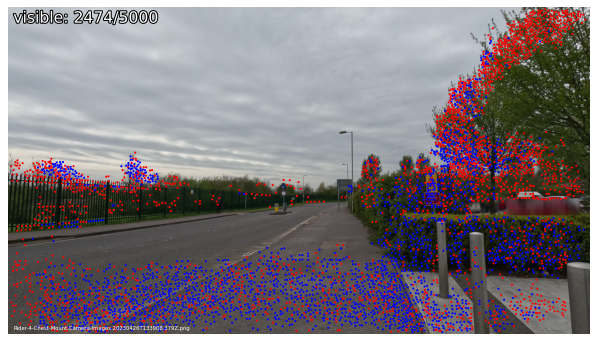

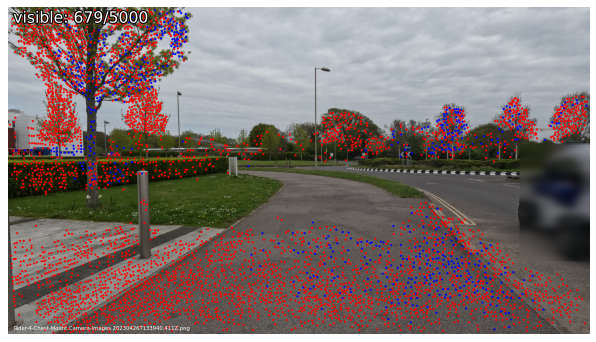

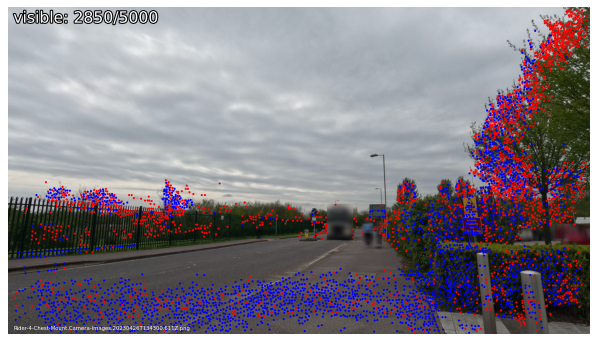

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=3)

# Localization
Now that we have a 3D map of the scene, we can localize any image.

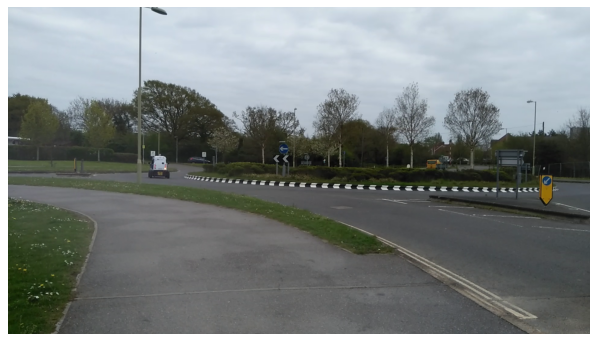

In [ ]:
!gdown https://drive.google.com/uc?id=1jMs67eIq0z283GSJkaA28b7DfX7oOnkF

query = '/content/Hierarchical-Localization/nokia4.png'
plot_images([read_image(query)], dpi=75)

For the query we again find image pairs via retrieval (NetVLAD) and then match local features (SuperPoint+SuperGlue).

In [ ]:
loc_retrieval_path = extract_features.main(retrieval_conf, images, image_list=[query], feature_path=retrieval_path)
pairs_from_retrieval.main(loc_retrieval_path, loc_pairs, query_list=[query], num_matched=5)
extract_features.main(feature_conf, images, image_list=[query], feature_path=feature_path)
match_features.main(matcher_conf, loc_pairs, features=feature_path, matches=match_path)

[2024/07/26 19:09:32 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/07/26 19:09:40 hloc INFO] Finished exporting features.
[2024/07/26 19:09:40 hloc INFO] Extracting image pairs from a retrieval database.
[2024/07/26 19:09:40 hloc INFO] Found 5 pairs.
[2024/07/26 19:09:40 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/07/26 19:09:41 hloc INFO] Finished exporting features.
[2024/07/26 19:09:41 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/5 [00:00<?, ?it/s]

[2024/07/26 19:09:42 hloc INFO] Finished exporting matches.


PosixPath('outputs/msf/feats-disk_matches-disk-lightglue_pairs-sfm.h5')

We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

found 620/1341 inlier correspondences.


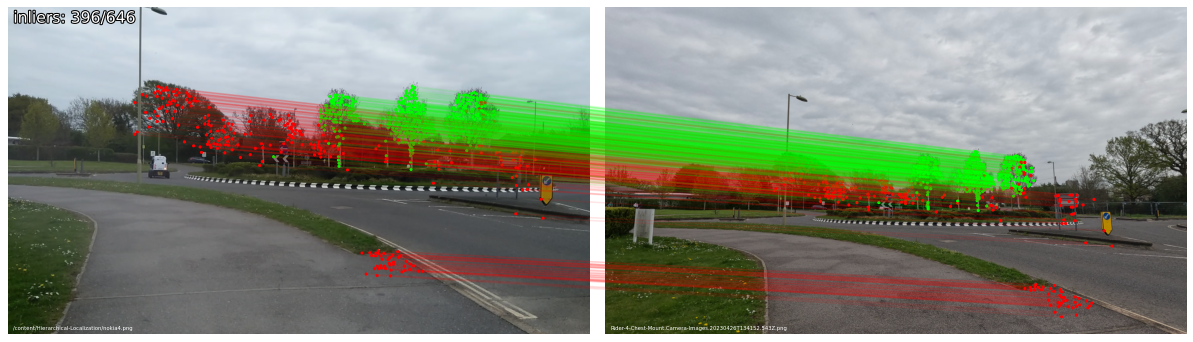

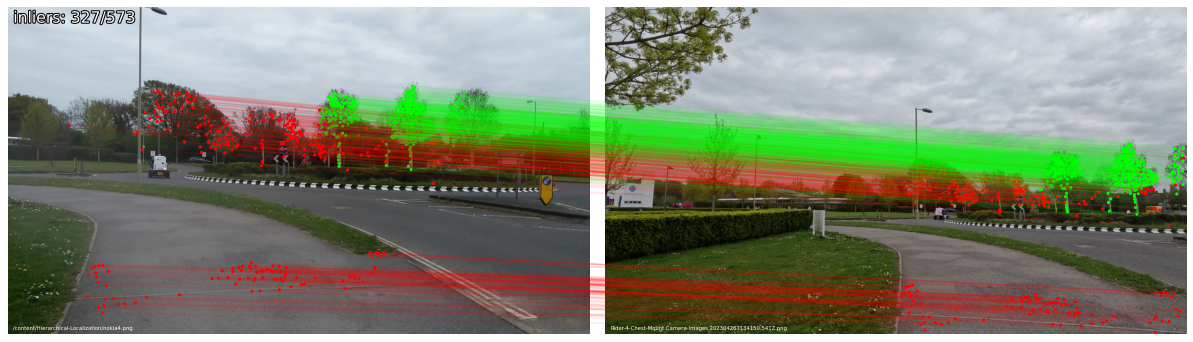

In [ ]:
import pycolmap
import csv

from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(query)

with open(loc_pairs, newline='') as f:
    reader = csv.reader(f, delimiter=' ')
    loc_pairs_in = list(reader)

loc_pairs_in=[row[1] for row in loc_pairs_in]

# ignore matches to self
loc_pairs_in.remove(query[1:])
ref_ids = [model.find_image_with_name(r).image_id for r in loc_pairs_in]

conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, feature_path, match_path)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [ ]:
pose = pycolmap.Image(cam_from_world=ret['cam_from_world'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# visualize 2D-3D correspodences
import numpy as np
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()